# Prelude

In [1]:
# print code version (hash of checked out version)
print("\nCurrent commit:")
!git log -1
print("\nChanges since last commit:")
!git status --short

# print date and time of script execution
import datetime
print("\nNotebook executed at at {} in following directory:".format(datetime.datetime.now()))
%cd ..

# Enable interactive plots (%matplotlib -l to list backends)
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from common import analysis, units, morphology, treeutils
import models.Gunay2008.gunay_model as gunay_model
import neuron; h = neuron.h
import bluepyopt.ephys as ephys

# Load custom synapse mechanisms
neuron.load_mechanisms('/home/luye/workspace/bgcellmodels/mechanisms/synapses')



Current commit:
commit 12ae3cc1b1de2b130f6566316991e38f0494e6db (HEAD -> nothreadsafe, origin/nothreadsafe)
Author: Lucas Koelman <lucas.koelman@gmail.com>
Date:   Mon May 21 20:03:44 2018 +0100

    Calibrate number & strength of STN afferent synapses

Changes since last commit:
 M ../../../README.md
 M ../../GilliesWillshaw/notebooks/calibrate_synapses_STN.ipynb
 M calibrate_synapses_GPE.ipynb
 M ../../KlmnNetMorpho/README.md

Notebook executed at at 2018-05-22 13:15:19.146055 in following directory:
/home/luye/workspace/bgcellmodels/models/Gunay2008


True

# Create cell

In [2]:
nrnsim = ephys.simulators.NrnSimulator(dt=0.025, cvode_active=False)

# Instantiate the cell
excluded = [] # mechanism names that will not be used
cell = gunay_model.define_cell("GUNAY2008_AXONLESS", exclude_mechs=excluded)
cell.instantiate(sim=nrnsim)
icell = cell.icell # cell instantiated in Hoc

# Fix model for GENESIS -> NEURON conversion
gunay_model.fix_comp_dimensions(cell)
# gunay_model.fix_num_compartments(cell, 100.0, nrnsim)

nseg = sum((sec.nseg for sec in icell.all))
print("Total number of compartments: {}".format(nseg))

Total number of compartments: 141


In [3]:
named_seclists =  {listname: list(getattr(icell, listname)) for listname in cell.seclist_names}
for k, v in named_seclists.items():
    if len(v)==0:
        named_seclists.pop(k) # don't include empty SectionLists
    else:
        print("{} : {} sections".format(k, len(v)))

somatic = named_seclists['somatic']
dendritic = named_seclists['basal']
axonal = named_seclists['axonal']

soma = somatic[0]
axon = axonal[0]
dend = dendritic[0]

all : 41 sections
somatic : 1 sections
basal : 39 sections
axonal : 1 sections


## Synapse Locations

A suitable compartment can be selected either using `treeutils.subtree_topology` or by using 
NEURON GUI -> Tools -> Distributed Mechanisms > Viewers > Shape Name

In [ ]:
# inspect topology to determine good synapse location
# print(treeutils.subtree_topology(soma, max_depth=1))

distal_sec = dendritic[31]
middle_sec = dendritic[25]
proximal_sec = dendritic[0]

print("Distal sec: " + distal_sec.name())

In [ ]:
# Show which compartments we are inserting synapses in
plt.figure()
ax = plt.subplot(111, projection='3d')

h.define_shape(sec=soma) # redefine shape if dimensions fixed
morphology.shapeplot(h, ax)
morphology.mark_locations(h, proximal_sec, 0.5, label='prox', markspec='or')
morphology.mark_locations(h, middle_sec, 0.5, label='mid', markspec='og')
morphology.mark_locations(h, distal_sec, 0.5, label='dist', markspec='ob')

plt.legend()
plt.show()

# Excitatory Synapse (STN)

## Experimental Synapse Properties

The article by <span style='color:blue;font-weight:bold'> Kita & Kitai (1991) </span> about GP physiology shows EPSPs triggered by STN stimulation in Figure 7:

- the long responses in figures A and B are not EPSPs, but IPSPs with reversed polarity because the cell was hyperpolarized below the reversal potential for GABA
- in **Fig. D, bottom trace** we see a large, long-duration EPSP likely triggered by multiple spikes and concurrent AMPA + NMDA receptor activations
    + EPSP with amplitude of 25 mV (deviation from baseline)
    + tau_rise ~= 5 ms
    + tau_decay ~= 16.5 ms
- In **Fig. A, top trace** we see a small-amplitude short EPSP before the longer-duration IPSP

The article by <span style='color:blue;font-weight:bold'> Hanson & Jaeger (2002) </span> shows EPSPs and the time course for short-term facilitation & depression in Figure 1.
- Fig. 1C, right panel shows STD effect on short time scale, and left panel on longer time scale

## Simulation Results

Multi-synapse rule of 3 synapses each with a synaptic conductance of 0.05 nS yields a PSP of the desired magnitude.

In [ ]:
# Set conductance so we get PSP of desired magnitude

spike_interval = 600.0
synapses, stims, netcons = [], [], []

for i, sec in enumerate((proximal_sec, middle_sec, distal_sec)):
    syn = h.GLUsyn(sec(0.5))
    
    stim = h.NetStim()
    stim.number = 1e9
    stim_rate = 50.0 # Hz
    stim.interval = stim_rate**-1*1e3
    stim.noise = 0
    stim.start = 750 + i*spike_interval
    
    nc = h.NetCon(stim, syn)
    nc.delay = 1.0
    
    # Common Synapse parameters
    nc.weight[0] = 1.0
    syn.tau_rec = 200.0
    syn.tau_facil = 800.0
    syn.U1 = P_release = 0.1 # release probability
    
    # AMPA synapse parameters
    conductance_nS = 0.025
    syn.gmax_AMPA = conductance_nS / P_release * 1e-3 # gmax is in [uS]
    syn.tau_r_AMPA = 1.0
    syn.tau_d_AMPA = 4.0
    
    # NMDA synapse parameters
    conductance_nS = 0.0
    syn.gmax_NMDA = conductance_nS / P_release * 1e-3
    syn.tau_r_AMPA = 3.7
    syn.tau_d_NMDA = 80
    
    # Save refs
    synapses.append(syn)
    stims.append(stim)
    netcons.append(nc)

In [ ]:
# Disable spiking for more accurate PSP measurement
# for sec in h.allsec():
#     sec.gmax_NaF = 0.0

# Alternative to disable spiking: hyperpolarizing current (like in article figure)
surf_factor = 0.01

istim = h.IClamp(soma(0.5))
istim.delay = 250
istim.dur = 1000
istim.amp = -0.68 * surf_factor # 100 pA = 0.1 nA

In [ ]:
# Define traces
rec_secs = {
    'soma': soma,
    'prox': proximal_sec,
    'mid': middle_sec,
    'dist': distal_sec,
    'synGLU': synapses[0],
}

trace_specs = {
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
#     'V_prox': {'var':'v', 'sec':'prox', 'loc':0.5},
#     'V_mid': {'var':'v', 'sec':'mid', 'loc':0.5},
#     'V_dist': {'var':'v', 'sec':'dist', 'loc':0.5},
    'gAMPA': {'pointp':'synGLU', 'var':'g_AMPA'},
    'gNMDA': {'pointp':'synGLU', 'var':'g_NMDA'},
    'Rrp': {'pointp':'synGLU', 'var':'R'},
    'Use': {'pointp':'synGLU', 'var':'Use'},
}

rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.v_init = -68.0
h.tstop = 2000.0
h.init()
# h.run()
nrnsim.run(h.tstop, h.dt)

# Plot recorded traces
plt.figure()
vrec_soma = vec_dict.pop('V_soma')
v_soma = vrec_soma.as_numpy()
t_soma = np.arange(len(v_soma)) * rec_dt
plt.plot(t_soma, v_soma)
plt.grid(True)

figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),

# Inhibitory Synapse

## Experimental Synapse Properties

For **GABA-B** receptors, the article by [Wu et al. (2005)](http://jpet.aspetjournals.org/content/312/3/1082) indicates that the component of the IPSC resulting from GABA-B receptors is about 15-40% of that resulting from GABA-A (GABA-A blocked -> peak current reaches 15-40% of control condition) dependent on location (proximal vs distal)

For <span style='color:red;font-weight:bold'>STR->GPe</span> inhibitory synapses, the article by <span style='color:blue;font-weight:bold'> Levine, Hull, Buchwald (1974) </span> about GP physiology shows following values in Figure 1:

- average IPSP trace shows approx. 5 mV dip from baseline
- exponential time constant for rising (dipping) phase : 66.0 ms
- exponential time constant for recovery phase : 100.0 ms

For <span style='color:red;font-weight:bold'>STR->GPe</span> inhibitory synapses, the article by <span style='color:blue;font-weight:bold'> Miguelez et al. (2012) </span> shows the following:

- Fig. 1A: IPSC_1 @ 10Hz : amplitude ~= 325 pA
- Fig. 1A: IPSC_5 @ 10Hz : amplitude ~= 825 pA

For <span style='color:red;font-weight:bold'>GPE->GPe</span> inhibitory synapses, the article by <span style='color:blue;font-weight:bold'> Miguelez et al. (2012) </span> shows the following:

- Fig. 1C: IPSC_1 @ 10Hz : amplitude ~= 950 pA
- Fig. 1C: IPSC_4 @ 10Hz : amplitude ~= 600 pA
- Fig. 5Ba: IPSC_1 in control condition : amplitude ~= 356 pA
- Fig. 5Bb: IPSC_1 in Parkinsonian condition : amplitude ~= 666 pA

## Simulation Results


In [ ]:
istim.amp = 0
istim = None

## Simulate GPe -> GPe

In [ ]:
# For GPE -> GPE: calibrate GABA-A + GABA-B simultaneously
spike_interval = 600.0
synapses, stims, netcons = [], [], []

for i, sec in enumerate((proximal_sec, middle_sec, distal_sec)):
    syn = h.GABAsyn(sec(0.5))
    
    stim = h.NetStim()
    stim.number = 10
    stim_rate = 100.0 # Hz
    stim.interval = stim_rate**-1*1e3
    stim.noise = 0
    stim.start = 750 + i*spike_interval
    
    nc = h.NetCon(stim, syn)
    nc.delay = 1.0
    
    # Common Synapse parameters
    nc.weight[0] = 1.0
    syn.tau_rec = 400.0
    syn.tau_facil = 1.0
    syn.U1 = P_release = 0.2 # release probability
    
    # GABA-A synapse parameters
    conductance_nS = 0.1
    syn.gmax_GABAA = conductance_nS / P_release * 1e-3 # gmax is in [uS]
    syn.tau_r_GABAA = 2.0
    syn.tau_d_GABAA = 5.0
    
    # GABA-B synapse parameters
    conductance_nS = 0.1
#     hill_factor = 0.21
    syn.gmax_GABAB = conductance_nS * 1e-3
    syn.tau_r_GABAB = 5.0 # initial species of signaling cascade
    syn.tau_d_GABAB = 10.0 # initial species of signaling cascade
    
    # Save refs
    synapses.append(syn)
    stims.append(stim)
    netcons.append(nc)

In [ ]:
# Define traces
rec_secs = {
    'soma': soma,
    'prox': proximal_sec,
    'mid': middle_sec,
    'dist': distal_sec,
    'synGABA': synapses[0],
}

trace_specs = {
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
#     'V_prox': {'var':'v', 'sec':'prox', 'loc':0.5},
#     'V_mid': {'var':'v', 'sec':'mid', 'loc':0.5},
#     'V_dist': {'var':'v', 'sec':'dist', 'loc':0.5},
    'gGABAA': {'pointp':'synGABA', 'var':'g_GABAA'},
    'gGABAB': {'pointp':'synGABA', 'var':'g_GABAB'},
    'Rrp': {'pointp':'synGABA', 'var':'Rrp'},
    'Use': {'pointp':'synGABA', 'var':'Use'},
    'Itot': {'pointp':'synGABA', 'var':'i'},
    'gtot' : {'pointp':'synGABA', 'var':'g'},
}

rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.v_init = -68.0
h.tstop = 2000.0
h.init()
# h.run()
nrnsim.run(h.tstop, h.dt)

# Plot recorded traces
plt.figure()
vrec_soma = vec_dict.pop('V_soma')
v_soma = vrec_soma.as_numpy()
t_soma = np.arange(len(v_soma)) * rec_dt
plt.plot(t_soma, v_soma)
plt.grid(True)

figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),

## Simulate STR -> GPe

In [ ]:
# For STR -> GPE: calibrate GABA-A + GABA-B simultaneously
spike_interval = 600.0
synapses, stims, netcons = [], [], []

for i, sec in enumerate((proximal_sec, middle_sec, distal_sec)):
    syn = h.GABAsyn(sec(0.5))
    
    stim = h.NetStim()
    stim.number = 10
    stim_rate = 10.0 # Hz
    stim.interval = stim_rate**-1*1e3
    stim.noise = 0
    stim.start = 750 + i*spike_interval
    
    nc = h.NetCon(stim, syn)
    nc.delay = 1.0
    
    # Common Synapse parameters
    nc.weight[0] = 1.0
    syn.tau_rec = 1.0
    syn.tau_facil = 500.0
    syn.U1 = P_release = 0.2 # release probability
    
    # GABA-A synapse parameters
    conductance_nS = 0.2 # TODO: peak conductance _after_ facilitation must equal that of GPE->GPE
    syn.gmax_GABAA = conductance_nS * 1e-3 # gmax is in [uS]
    syn.tau_r_GABAA = 2.0
    syn.tau_d_GABAA = 5.0
    
    # GABA-B synapse parameters
    conductance_nS = 0
#     hill_factor = 0.21
    syn.gmax_GABAB = conductance_nS * 1e-3
    syn.tau_r_GABAB = 5.0 # initial species of signaling cascade
    syn.tau_d_GABAB = 10.0 # initial species of signaling cascade
    
    # Save refs
    synapses.append(syn)
    stims.append(stim)
    netcons.append(nc)

In [ ]:
# Define traces
rec_secs = {
    'soma': soma,
    'prox': proximal_sec,
    'mid': middle_sec,
    'dist': distal_sec,
    'synGABA': synapses[0],
}

trace_specs = {
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
#     'V_prox': {'var':'v', 'sec':'prox', 'loc':0.5},
#     'V_mid': {'var':'v', 'sec':'mid', 'loc':0.5},
#     'V_dist': {'var':'v', 'sec':'dist', 'loc':0.5},
    'gGABAA': {'pointp':'synGABA', 'var':'g_GABAA'},
    'gGABAB': {'pointp':'synGABA', 'var':'g_GABAB'},
    'Rrp': {'pointp':'synGABA', 'var':'Rrp'},
    'Use': {'pointp':'synGABA', 'var':'Use'},
    'Itot': {'pointp':'synGABA', 'var':'i'},
    'gtot' : {'pointp':'synGABA', 'var':'g'},
}

rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.v_init = -68.0
h.tstop = 2000.0
h.init()
# h.run()
nrnsim.run(h.tstop, h.dt)

# Plot recorded traces
plt.figure()
vrec_soma = vec_dict.pop('V_soma')
v_soma = vrec_soma.as_numpy()
t_soma = np.arange(len(v_soma)) * rec_dt
plt.plot(t_soma, v_soma)
plt.grid(True)

figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),

In [ ]:
# Calibrate GABAA conductance so we get PSP of desired magnitude

spike_interval = 0.0
synapses, stims, netcons = [], [], []

conductance_nS = 0.1
tau_rise = 66.0
tau_decay = 100.0

for i, sec in enumerate((proximal_sec,)):
    syn = h.GABAsyn(sec(0.5))
    
    stim = h.NetStim()
    stim.number = 1 # need barrage to trigger signaling cascade
    stim.noise = 0
    stim.start = 500 + i*spike_interval
    
    nc = h.NetCon(stim, syn)
    nc.delay = 1.0
    
    # Synapse parameters
    nc.weight[0] = conductance_nS # conductance in [nS]
    # syn.gmax_AMPA = 0.01 # [uS] or set netcon weight in [nS]
    syn.gmax_GABAB = 0.0
    syn.tau_r_GABAA = tau_rise
    syn.tau_d_GABAA = tau_decay
    syn.U1 = 1.0 # release probability
    
    # Save refs
    synapses.append(syn)
    stims.append(stim)
    netcons.append(nc)

In [ ]:
# Calibrate GABAB conductance so we get PSP of desired magnitude

spike_interval = 0.0
synapses, stims, netcons = [], [], []

# NOTE: rise and decay time represent that of first quantity in signaling
#       cascade, NOT those of the conductance or IPSP
conductance_nS = 0.0375
tau_rise = 5.0 # 66.0
tau_decay = 10.0 # 100.0

for i, sec in enumerate((proximal_sec,)):
    syn = h.GABAsyn(sec(0.5))
    
    stim = h.NetStim()
    stim.number = 8 # need barrage to trigger signaling cascade
    stim_rate = 100.0 # Hz
    stim.interval = stim_rate**-1*1e3
    stim.noise = 0
    stim.start = 500 + i*spike_interval
    
    nc = h.NetCon(stim, syn)
    nc.delay = 1.0
    
    # Synapse parameters
    nc.weight[0] = conductance_nS # conductance in [nS]
#     syn.gmax_GABAB = conductance_nS * 1e-3
    syn.gmax_GABAA = 0.0
    syn.tau_r_GABAB = tau_rise
    syn.tau_d_GABAB = tau_decay
    syn.U1 = 1.0 # release probability
    
    # Save refs
    synapses.append(syn)
    stims.append(stim)
    netcons.append(nc)

In [ ]:
# Define traces
rec_secs = {
    'soma': soma,
    'prox': proximal_sec,
    'mid': middle_sec,
    'dist': distal_sec,
    'synGABA': synapses[0],
}

trace_specs = {
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
#     'V_prox': {'var':'v', 'sec':'prox', 'loc':0.5},
#     'V_mid': {'var':'v', 'sec':'mid', 'loc':0.5},
#     'V_dist': {'var':'v', 'sec':'dist', 'loc':0.5},
    'gGABAA': {'pointp':'synGABA', 'var':'g_GABAA'},
    'gGABAB': {'pointp':'synGABA', 'var':'g_GABAB'},
    'Rrp': {'pointp':'synGABA', 'var':'Rrp'},
    'Use': {'pointp':'synGABA', 'var':'Use'},
}

rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.v_init = -68.0
h.tstop = 2000.0
h.init()
# h.run()
nrnsim.run(h.tstop, h.dt)

# Plot recorded traces
plt.figure()
vrec_soma = vec_dict.pop('V_soma')
v_soma = vrec_soma.as_numpy()
t_soma = np.arange(len(v_soma)) * rec_dt
plt.plot(t_soma, v_soma)
plt.grid(True)

figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),

# Excitatory + Inhibitory synapses

The Observations Database contains following observations that may help in configuring the distribution of synapses on the GPe dendritic tree:

## Firing Pattern

- firing rate
    + for prototypic GPe cells, the mean firing rate is 47.4 +/- 6.1 Hz
    + for arkypallidal GPe cells, the mean firing rate is 8.9 +/- 1.9 Hz
    + in general firing rate of GPe cells has been reported between 50-70 Hz, and between 20-100 Hz



## GPe Synapse Information

- average number of synaptic boutons/contacts from neighboring GPe cells that are closeby is 581
    + closeby = target cell is in medial region of origin cell's dendritic field


- average number of synaptic boutons/contacts from neighboring GPe cells that are farther is 264
    + farther = target cell is in border region of origin cell's dendritic field


## STN Synapse Information

- number of synaptic boutons on GPe cells that come from STN afferents is 135
    + ! this estimate is not an error -> it is mentioned that this is very low compared to the ~10.000 Striatal boutons


## Str Synapse Information

- Average number of striatal boutons per GPe cell is 10622
- Average number of boutons on one GPe cell coming from one axon belonging to a Striatal indirect pathway neuron is 226
- Average number of boutons on one GPe cell coming from one axon belonging to a Striatal direct pathway neuron is 123

## Summary

Number of boutons per afferent population:

| GPe.clo | GPe.far | GPe.tot | Str.D1 | Str.D2 | Str.tot | STN |
|---------|---------|---------|--------|--------|---------|-----|
| 581     | 264     | 845     | 3540   | 7081   | 10622   | 135 |

Fraction of boutons per afferent population:

| GPe  | Str   | STN  |
|------|-------|------|
| 7.3% | 91.5% | 1.2% |



## Make GPe (GABA) Synapses

In [4]:
from common.protocols import pick_random_segments

rng_seed = 8
highest_indices = {rng_seed: 0} # max high_index for each low_index (seed)
stim_data = {}
rec_secs = {}


# Filter to select proximal, larger-diam dendritic segments
num_gpe_syn = 10

# see Gillies cell diagram
# can_have_synapse = lambda seg: seg.diam > 1.0
h.distance(0, 0.5, sec=soma)
can_have_synapse = lambda seg: h.distance(1, seg.x, sec=seg.sec) < 120.0
target_segs = pick_random_segments(dendritic, num_gpe_syn, can_have_synapse)

# Make synapses
for i_seg, target_seg in enumerate(target_segs):
    
    tstart = 300
    stim_rate = 50.0 # discharge rate in between pauses
    stim_interval = stim_rate**-1*1e3
    pause_dur = 300.0 # duration of pauses
    discharge_dur = 3000.0 # duration of firing in between pauses
    dur_max_ms = 10000.0
    

    # RNG settings
    num_indep_repicks = dur_max_ms / stim_interval + 1000
    low_index = rng_seed
    highest_index = highest_indices.get(low_index, 0)
    high_index = int(highest_index + num_indep_repicks)
    highest_indices[low_index] = high_index # update highest index

    # MCellRan4: each stream should be statistically independent as long as 
    # the highindex values differ by more than the eventual length of the stream.
    # See http://www.neuron.yale.edu/neuron/static/py_doc/programming/math/random.html?highlight=MCellRan4
    stimrand = h.Random() # see CNS2014 Dura-Bernal example or EPFL cell synapses.hoc file
    stimrand.MCellRan4(high_index, low_index)
    stimrand.negexp(1) # if num arrivals is poisson distributed, ISIs are negexp-distributed

    # make bursting NetStim
    stimsource = h.BurstStim()
    stimsource.fast_invl = stim_interval
    stimsource.slow_invl = pause_dur
    stimsource.burst_len = discharge_dur*1e-3*stim_rate
    stimsource.start = tstart
    stimsource.noise = 1.0
    stimsource.noiseFromRandom(stimrand) # Set it to use this random number generator
    
    
    # GABA Synapse
    syn = h.GABAsyn(target_seg)
    nc = h.NetCon(stimsource, syn)
    nc.delay = 1.0
    nc.weight[0] = 1.0
    
    # Synapse parameters
    tau_rise = 2.0
    tau_decay = 6.0
    tau_rec = 17300.0
    tau_facil = 1.0
    P_release = 0.2
    hill_factor = 0.35
    
    peak_factor = 250 # 1 / P_release
    syn.gmax_GABAA = 7.0 * peak_factor * 1e-3 # conductance in [nS]
    syn.tau_r_GABAA = 2.0
    syn.tau_d_GABAA = 6.0
    
    peak_factor = 1 / hill_factor
    syn.gmax_GABAB = 7.0 * peak_factor * 1e-3
    syn.tau_r_GABAB = 5.0
    syn.tau_d_GABAB = 10.0
    
    syn.tau_rec = tau_rec
    syn.tau_facil = tau_facil
    syn.U1 = P_release
    
    # Save inputs
    stim_data.setdefault('NetStims', []).append(stimsource)
    stim_data.setdefault('RNGs', []).append(stimrand)
    stim_data.setdefault('GPE_NetCons', []).append(nc)
    stim_data.setdefault('GPE_synapses', []).append(syn)

# Print values - sanity check
last_syn = stim_data['GPE_synapses'][-1]
for attr in 'gmax_GABAA', 'gmax_GABAB':
    print("{} :\t\t{}".format(attr, getattr(last_syn, attr)))

DEBUG@protocols.py:58>Found 137 eligible candidate segments
DEBUG@protocols.py:80>Picked 10 target segments.


gmax_GABAA :		1.75
gmax_GABAB :		0.02


## Make STN (GLU) Synapses

In [5]:
# Filter to select proximal, larger-diam dendritic segments
num_syn = 14
can_have_synapse = lambda seg: seg.diam <= 1.0
target_segs = pick_random_segments(dendritic, num_syn, can_have_synapse)

# Clear saved references -> garbage collector should delete objects
rec_secs = {}
stim_data['STN_NetCons'] = []
stim_data['STN_synapses'] = []

# Make synapses
for i_seg, target_seg in enumerate(target_segs):
    
    tstart = 300
    stim_rate = 120.0 # discharge rate in between pauses
    stim_interval = stim_rate**-1*1e3
    discharge_dur = 30.0 # duration of firing in between pauses
    pause_dur = 100.0 - discharge_dur # duration of pauses -> bursts @ ~ 10 Hz
    dur_max_ms = 10000.0
    

    # RNG settings
    num_indep_repicks = dur_max_ms / stim_interval + 1000
    low_index = rng_seed
    highest_index = highest_indices.get(low_index, 0)
    high_index = int(highest_index + num_indep_repicks)
    highest_indices[low_index] = high_index # update highest index

    # MCellRan4: each stream should be statistically independent as long as 
    # the highindex values differ by more than the eventual length of the stream.
    # See http://www.neuron.yale.edu/neuron/static/py_doc/programming/math/random.html?highlight=MCellRan4
    stimrand = h.Random() # see CNS2014 Dura-Bernal example or EPFL cell synapses.hoc file
    stimrand.MCellRan4(high_index, low_index)
    stimrand.negexp(1) # if num arrivals is poisson distributed, ISIs are negexp-distributed

    # make bursting NetStim
    stimsource = h.BurstStim()
    stimsource.fast_invl = stim_interval
    stimsource.slow_invl = pause_dur
    stimsource.burst_len = discharge_dur*1e-3*stim_rate # ((1.0/pause_rate_hz) - pause_dur) * stim_rate
    assert stimsource.burst_len > 0
    
    stimsource.start = tstart
    stimsource.noise = 1.0
    stimsource.noiseFromRandom(stimrand) # Set it to use this random number generator
    
    # Make GLU synapse
    syn = h.GLUsyn(target_seg)
    nc = h.NetCon(stimsource, syn)
    nc.delay = 1.0
    nc.weight[0] = 1.0
    
    # Common Synapse parameters
    syn.tau_rec = 200.0
    syn.tau_facil = 800.0
    syn.U1 = P_release = 0.1 # release probability
    
    # AMPA synapse parameters
    conductance_nS = 3.44
    peak_factor = 4.0
    syn.gmax_AMPA = conductance_nS * peak_factor * 1e-3 # gmax is in [uS]
    syn.tau_r_AMPA = 1.0
    syn.tau_d_AMPA = 4.0
    
    # NMDA synapse parameters
    conductance_nS = 7.0 # 7 nS
    peak_factor = 2.0
    syn.gmax_NMDA = conductance_nS * peak_factor * 1e-3
    syn.tau_r_NMDA = 3.7
    syn.tau_d_NMDA = 80
    
    # Save inputs
    stim_data.setdefault('NetStims', []).append(stimsource)
    stim_data.setdefault('RNGs', []).append(stimrand)
    stim_data.setdefault('STN_NetCons', []).append(nc)
    stim_data.setdefault('STN_synapses', []).append(syn)

# Print values - sanity check
last_syn = stim_data['STN_synapses'][-1]
for attr in 'gmax_AMPA', 'gmax_NMDA':
    print("{} :\t\t{}".format(attr, getattr(last_syn, attr)))

DEBUG@protocols.py:58>Found 137 eligible candidate segments
DEBUG@protocols.py:80>Picked 14 target segments.


gmax_AMPA :		0.01376
gmax_NMDA :		0.014


## Make STR (GABA) Synapses

In [6]:
# Clear saved references -> garbage collector should delete objects
rec_secs = {}
stim_data['STR_NetCons'] = []
stim_data['STR_synapses'] = []

# Filter to select proximal, larger-diam dendritic segments
num_gpe_syn = 10

# see Gillies cell diagram
# can_have_synapse = lambda seg: seg.diam > 1.0
h.distance(0, 0.5, sec=soma)
can_have_synapse = lambda seg: h.distance(1, seg.x, sec=seg.sec) < 120.0
target_segs = pick_random_segments(dendritic, num_gpe_syn, can_have_synapse)

# Make synapses
for i_seg, target_seg in enumerate(target_segs):
    
    tstart = 300
    stim_rate = 50.0 # discharge rate in between pauses
    stim_interval = stim_rate**-1*1e3
    pause_dur = 300.0 # duration of pauses
    discharge_dur = 3000.0 # duration of firing in between pauses
    dur_max_ms = 10000.0
    

    # RNG settings
    num_indep_repicks = dur_max_ms / stim_interval + 1000
    low_index = rng_seed
    highest_index = highest_indices.get(low_index, 0)
    high_index = int(highest_index + num_indep_repicks)
    highest_indices[low_index] = high_index # update highest index

    # MCellRan4: each stream should be statistically independent as long as 
    # the highindex values differ by more than the eventual length of the stream.
    # See http://www.neuron.yale.edu/neuron/static/py_doc/programming/math/random.html?highlight=MCellRan4
    stimrand = h.Random() # see CNS2014 Dura-Bernal example or EPFL cell synapses.hoc file
    stimrand.MCellRan4(high_index, low_index)
    stimrand.negexp(1) # if num arrivals is poisson distributed, ISIs are negexp-distributed

    # make bursting NetStim
    stimsource = h.BurstStim()
    stimsource.fast_invl = stim_interval
    stimsource.slow_invl = pause_dur
    stimsource.burst_len = discharge_dur*1e-3*stim_rate
    stimsource.start = tstart
    stimsource.noise = 1.0
    stimsource.noiseFromRandom(stimrand) # Set it to use this random number generator
    
    
    # GABA Synapse
    syn = h.GABAsyn(target_seg)
    nc = h.NetCon(stimsource, syn)
    nc.delay = 1.0
    nc.weight[0] = 1.0
    
    # Synapse parameters
    tau_rise = 2.0
    tau_decay = 6.0
    tau_rec = 17300.0
    tau_facil = 1.0
    P_release = 0.2
    hill_factor = 0.35
    
    peak_factor = 250 # 1 / P_release
    syn.gmax_GABAA = 7.0 * peak_factor * 1e-3 # conductance in [nS]
    syn.tau_r_GABAA = 2.0
    syn.tau_d_GABAA = 6.0
    
    peak_factor = 1 / hill_factor
    syn.gmax_GABAB = 7.0 * peak_factor * 1e-3
    syn.tau_r_GABAB = 5.0
    syn.tau_d_GABAB = 10.0
    
    syn.tau_rec = tau_rec
    syn.tau_facil = tau_facil
    syn.U1 = P_release
    
    # Save inputs
    stim_data.setdefault('NetStims', []).append(stimsource)
    stim_data.setdefault('RNGs', []).append(stimrand)
    stim_data.setdefault('STR_NetCons', []).append(nc)
    stim_data.setdefault('STR_synapses', []).append(syn)

# Print values - sanity check
last_syn = stim_data['STR_synapses'][-1]
for attr in 'gmax_GABAA', 'gmax_GABAB':
    print("{} :\t\t{}".format(attr, getattr(last_syn, attr)))

DEBUG@protocols.py:58>Found 137 eligible candidate segments
DEBUG@protocols.py:80>Picked 10 target segments.


gmax_GABAA :		1.75
gmax_GABAB :		0.02


## Plot Synapse Locations

<IPython.core.display.Javascript object>


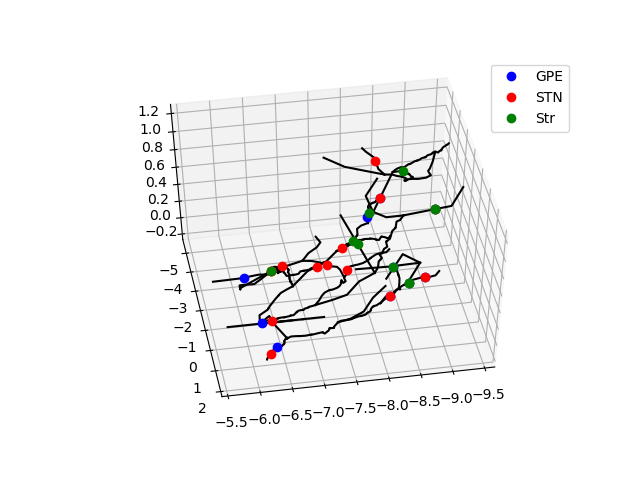

In [8]:
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.view_init(90,90) # set azimut and elevation
# ax.set_zlim((-1,1)) # prevent rounding errors
# ax.set_axis_off() # hide x,y,z axes and grid

# Plot shape of our cell
h.define_shape(sec=soma) # for cells without 3D morphology
morphology.shapeplot(h, ax)

# Plot synapse locations
for i, syn in enumerate(stim_data['GPE_synapses']):
    seg = syn.get_segment()
    label = 'GPE' if i==0 else None
    morphology.mark_locations(h, seg.sec, seg.x, label=label, markspec='ob')

for i, syn in enumerate(stim_data['STN_synapses']):
    seg = syn.get_segment()
    label = 'STN' if i==0 else None
    morphology.mark_locations(h, seg.sec, seg.x, label=label, markspec='or')


for i, syn in enumerate(stim_data['STR_synapses']):
    seg = syn.get_segment()
    label = 'Str' if i==0 else None
    morphology.mark_locations(h, seg.sec, seg.x, label=label, markspec='og')

    
plt.legend()
plt.show()

## Record & Run

In [9]:
# Define traces
rec_secs = {
    'soma': soma,
    'soma_spiker': h.NetCon(soma(0.5)._ref_v, None, -10.0, 0, 0),
#     'prox': proximal_seg,
#     'mid': middle_seg,
#     'dist': distal_seg,
#     'synGABA': synapses[0],
}

trace_specs = {
    't_global': {'var': 't'},
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
    'AP_soma': {'netcon': 'soma_spiker'},
    # STN Synapse variables
    'gAMPA_stn': {'pointp':'synSTN0', 'var':'g_AMPA'},
    'gNMDA_stn': {'pointp':'synSTN0', 'var':'g_NMDA'},
    'iAMPA_stn': {'pointp':'synSTN0', 'var':'i_AMPA'},
    'iNMDA_stn': {'pointp':'synSTN0', 'var':'i_NMDA'},
    'itot_stn':  {'pointp':'synSTN0', 'var':'i'},
    # GPE Synapse variables
    'gGABAA_gpe': {'pointp':'synGPE0', 'var':'g_GABAA'},
    'gGABAB_gpe': {'pointp':'synGPE0', 'var':'g_GABAB'},
    'iGABAA_gpe': {'pointp':'synGPE0', 'var':'i_GABAA'},
    'iGABAB_gpe': {'pointp':'synGPE0', 'var':'i_GABAB'},
    'itot_gpe':  {'pointp':'synGPE0', 'var':'i'},
    # Striatal synapse variables
    'gGABAA_str': {'pointp':'synSTR0', 'var':'g_GABAA'},
    'gGABAB_str': {'pointp':'synSTR0', 'var':'g_GABAB'},
    'iGABAA_str': {'pointp':'synSTR0', 'var':'i_GABAA'},
    'iGABAB_str': {'pointp':'synSTR0', 'var':'i_GABAB'},
    'itot_str':  {'pointp':'synSTR0', 'var':'i'},
}

# Record spikes at synapses
for pop_label in 'STN', 'GPE', 'STR':
    for i_syn, nc in enumerate(stim_data[pop_label + '_NetCons']):
        con_label = "con{}{}".format(pop_label, i_syn)
        syn_label = "syn{}{}".format(pop_label, i_syn)
        rec_secs[con_label] = nc
        rec_secs[syn_label] = nc.syn()
        trace_specs['AP_'+con_label] = {'netcon': con_label}
        trace_specs['i_'+syn_label] = {'pointp': syn_label, 'var':'i'}

rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

In [11]:
# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.v_init = -68.0
h.tstop = 5000.0
h.init()

import time
tstart = time.time()
nrnsim.run(h.tstop, h.dt)
tstop = time.time()
cputime = tstop - tstart
num_segments = sum((sec.nseg for sec in h.allsec()))
print("Simulated {} segments for {} ms in {} ms CPU time".format(
        num_segments, h.tstop, cputime))

Simulated 141 segments for 5000.0 ms in 47.215474844 ms CPU time


## Plot Voltage Traces

<IPython.core.display.Javascript object>


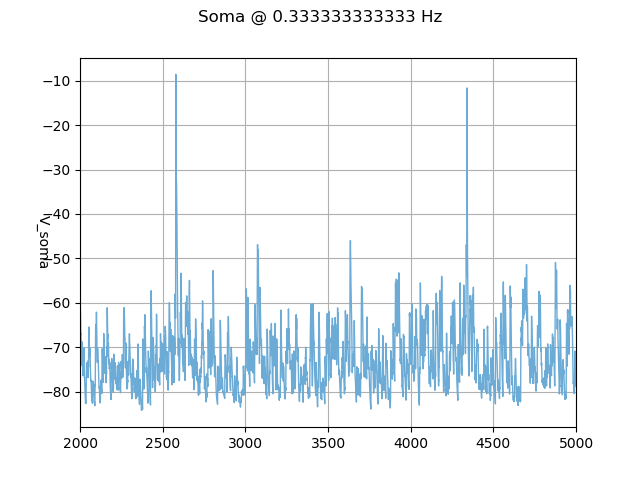

In [15]:
# t_global = vec_dict.pop('t_global').as_numpy() # inconsistent if dt != rec_dt 
interval = (2000, h.tstop)

# Plot somatic voltage traces
v_soma = vec_dict['V_soma'].as_numpy()
t_rec = np.arange(len(v_soma)) * rec_dt

spikes_soma = vec_dict['AP_soma'].as_numpy()
spike_range = (spikes_soma > interval[0]) & (spikes_soma <= interval[1])
soma_rate = len(spikes_soma[spike_range]) / float(interval[1]-interval[0]) * 1e3

analysis.plotTraces(vec_dict, rec_dt, interval, includeTraces=['V_soma'], title="Soma @ {} Hz".format(soma_rate))

## Plot Spike Trains

<IPython.core.display.Javascript object>


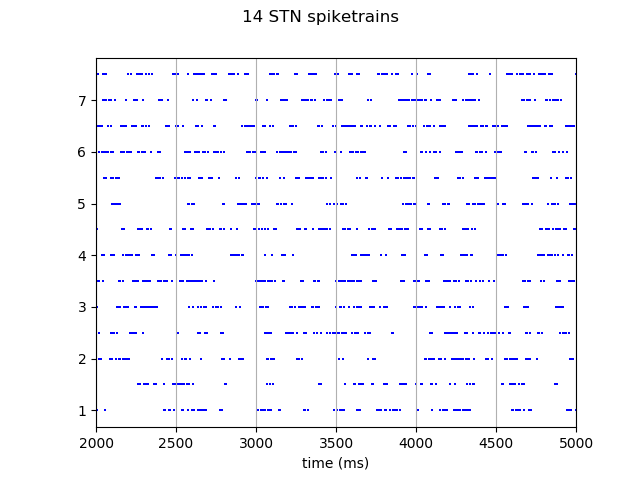

<IPython.core.display.Javascript object>


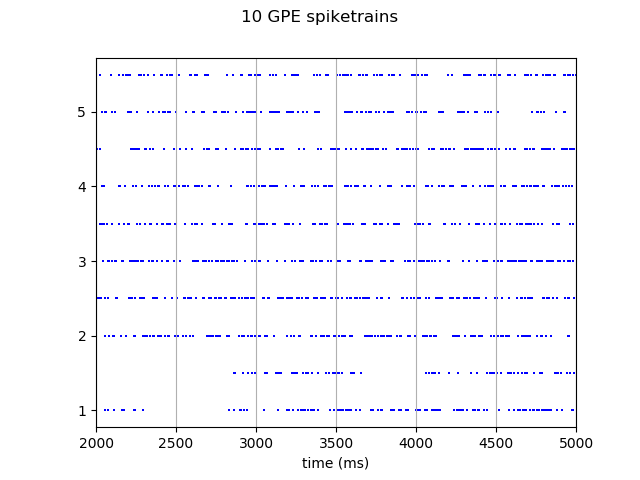

<IPython.core.display.Javascript object>


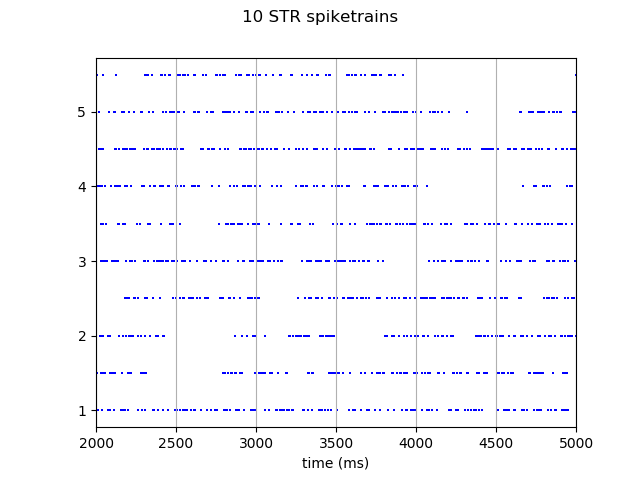

In [16]:
# Plot spikes
for pop_label in 'STN', 'GPE', 'STR':
    
    spike_data = analysis.match_traces(
                    vec_dict, 
                    lambda label: label.startswith('AP_con'+pop_label))
    
    analysis.plotRaster(
                    spike_data, interval,
                    color='b',
                    title='{} {} spiketrains'.format(
                        len(spike_data), pop_label))

## Plot Synaptic Currents

<IPython.core.display.Javascript object>


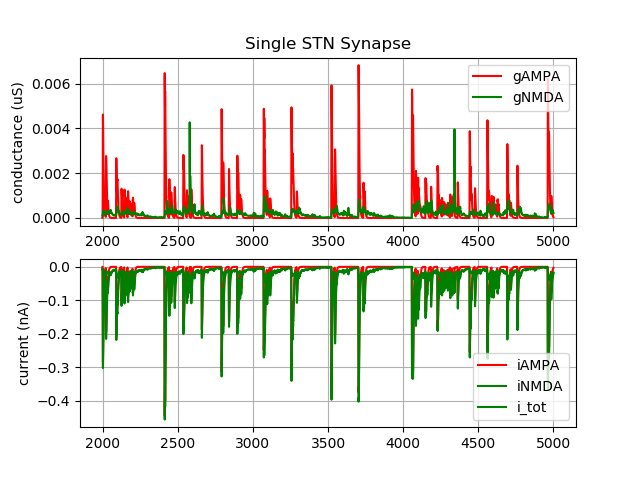

<IPython.core.display.Javascript object>


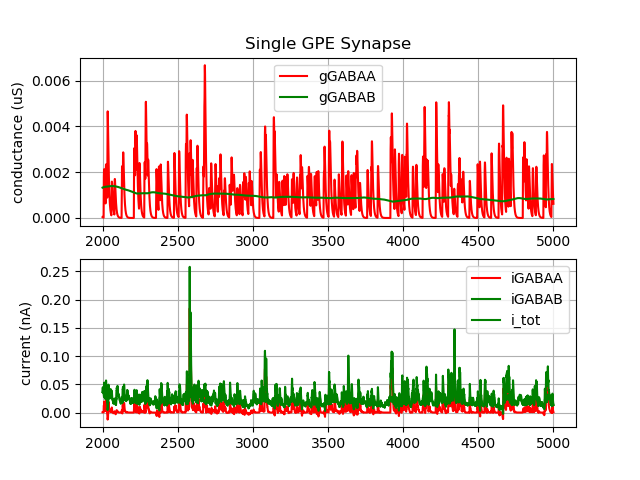

<IPython.core.display.Javascript object>


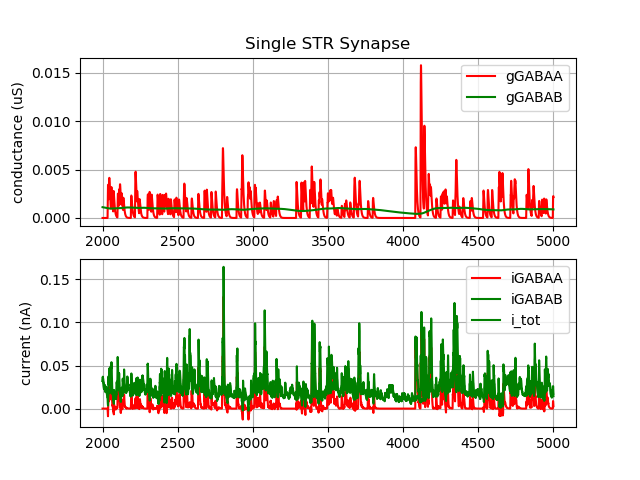

<IPython.core.display.Javascript object>


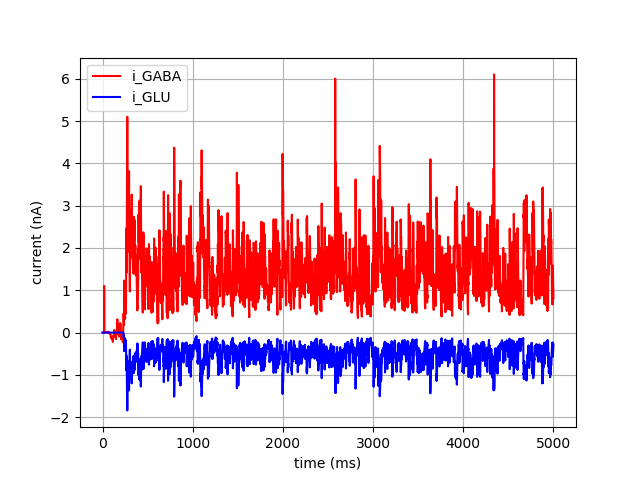

In [18]:
# Plot synaptic variables
a = int(interval[0] // rec_dt)
b = int(interval[1] // rec_dt)
t_plot = t_rec[a:b]

NTR = { # neurotransmitter receptors
    'STN': ('AMPA', 'NMDA'),
    'GPE': ('GABAA', 'GABAB'),
    'STR': ('GABAA', 'GABAB')
}

# Plot GLU synapse variables
for pop_label in 'STN', 'GPE', 'STR':
    fig, axes = plt.subplots(2,1)
    
    ntr = NTR[pop_label]
    x_vec0 = vec_dict['g{}_{}'.format(ntr[0], pop_label.lower())].as_numpy()
    x_vec1 = vec_dict['g{}_{}'.format(ntr[1], pop_label.lower())].as_numpy()

    for i in range(len(ntr)):
        # plot conductances
        g_vec = vec_dict['g{}_{}'.format(ntr[i], pop_label.lower())].as_numpy()
        label = 'g{}'.format(ntr[i])
        axes[0].plot(t_plot, g_vec[a:b], 'rgb'[i], label=label)
        
        # plot currents
        i_vec = vec_dict['i{}_{}'.format(ntr[i], pop_label.lower())].as_numpy()
        label = 'i{}'.format(ntr[i])
        axes[1].plot(t_plot, i_vec[a:b], 'rgb'[i], label=label)
    
    # total current
    i_vec = vec_dict['itot_{}'.format(pop_label.lower())].as_numpy()
    axes[1].plot(t_plot, i_vec[a:b], 'g', label='i_tot')
    
    axes[0].set_ylabel('conductance (uS)')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_title('Single {} Synapse'.format(pop_label))

    axes[1].set_ylabel('current (nA)')
    axes[1].legend()
    axes[1].grid(True)



# Plot total GABA and GLU current from all synapses
itot_GABA = vec_dict['i_synGPE0'].as_numpy()
for i in range(1, len(stim_data['GPE_synapses'])):
    itot_GABA += vec_dict['i_synGPE{}'.format(i)].as_numpy()
for i in range(0, len(stim_data['STR_synapses'])):
    itot_GABA += vec_dict['i_synSTR{}'.format(i)].as_numpy()

itot_GLU = vec_dict['i_synSTN0'].as_numpy()
for i in range(1, len(stim_data['STN_synapses'])):
    itot_GLU += vec_dict['i_synSTN{}'.format(i)].as_numpy()

plt.figure()
plt.plot(t_rec, itot_GABA, 'r', label='i_GABA')
plt.plot(t_rec, itot_GLU, 'b', label='i_GLU')
plt.ylabel('current (nA)')
plt.xlabel('time (ms)')
plt.legend()
plt.grid()
plt.show()
# Plot remaining traces
# figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),